# Sentiment Analysis Project

This project explores how to build a simple yet effective sentiment analyzer in Python.  
The goal is to understand how sentiment scoring works, experiment with real text data, and create a tool that can classify text as positive, negative, or neutral.

## Objectives

- Build a basic sentiment analyzer using Python and VADER.
- Wrap the functionality in a clean, reusable Python class.
- Load and analyze real sentiment data from sources like Kaggle or API's.
- Evaluate accuracy and experiment with improvements.
- Present results and insights in this notebook.

## Project Structure

- `sentiment_analyzer.py`: Contains the sentiment analysis class.
- `notebook.ipynb`: Demonstrates how to use the analyzer and evaluates it on real data.
- `data/`: Folder for any datasets used.

## Steps

1. Implement the sentiment analyzer in Python.
2. Import the analyzer into this notebook.
3. Load a dataset of text with sentiment labels.
4. Run predictions and measure performance.
5. Visualize results and document findings.


## Abstract

This project develops an end to end sentiment analysis workflow using real financial news data and a custom Python implementation. I collected headlines from multiple industries through the NewsAPI service and organised them into a structured dataset containing article metadata and industry labels. Using a VADER based SentimentAnalyzer, I computed sentiment scores and categorical labels for each headline and combined these results with the raw data to create an industry level sentiment dataset.

A series of visualisations was used to explore the distribution of sentiment across industries, the balance of positive, neutral, and negative news, and the variability of sentiment over time. The results show that neutral sentiment dominates most industries, while positive sentiment is more common in sectors such as Technology, Telecom, and Retail and Apparel. Food and Beverage shows a noticeably lower average sentiment and a higher proportion of negative headlines. Across all industries, sentiment scores display considerable variability, indicating that news tone fluctuates in response to sector specific developments.

This project demonstrates how sentiment analysis techniques can be applied to real time news data and highlights meaningful differences in sentiment across major economic sectors. The workflow provides a strong foundation for further analysis, including predictive modelling or multi source sentiment comparison.


## Getting Started

After creating the Python file, run the cell below to import your analyzer and start testing it.

In [61]:
import numpy as np 
import pandas as pd 
import requests
import time 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [4]:
from sentiment_analyzer import SentimentAnalyzer 

sa = SentimentAnalyzer()

sentences = ["I love this movie, it was fantastic!",
    "The food was okay, nothing special.",
    "This is the worst service I have ever experienced."]

for s in sentences: 
    result = sa.analyze(s)
    print(f"Text: {s}")
    print(f"Scores: {result}")
    print()

Text: I love this movie, it was fantastic!
Scores: {'neg': 0.0, 'neu': 0.331, 'pos': 0.669, 'compound': 0.8439, 'label': 'positive'}

Text: The food was okay, nothing special.
Scores: {'neg': 0.277, 'neu': 0.49, 'pos': 0.233, 'compound': -0.092, 'label': 'negative'}

Text: This is the worst service I have ever experienced.
Scores: {'neg': 0.369, 'neu': 0.631, 'pos': 0.0, 'compound': -0.6249, 'label': 'negative'}



### Sentiment Analyzer Test

This cell imports the `SentimentAnalyzer` class and runs it on three example sentences.  
For each sentence, the analyzer returns VADER sentiment scores (`neg`, `neu`, `pos`, and `compound`) along with a final label based on the compound value.

The output shows that the model correctly identifies:
- A clearly positive sentence as **positive**  
- A mixed or neutral sentence as **negative** (due to slightly negative weighting)  
- A strongly negative sentence as **negative**

This confirms that the sentiment analyzer is functioning as expected and is able to classify text sentiment using the VADER lexicon from NLTK.  


## Fetching Data 
we will use NEW's API to get our data using the reuest library 


### Building The Data Set 

In [39]:
industries = {
    "Technology": [
        "AAPL", "MSFT", "NVDA", "GOOGL", "META", "AMD", "INTC", "IBM",
        "ORCL", "CRM", "ADBE", "TSM", "ASML", "SAP"
    ],

    "Energy": [
        "XOM", "CVX", "BP", "SHEL", "COP", "EOG", "SLB", "HAL",
        "PSX", "MPC"
    ],

    "Financials": [
        "JPM", "GS", "MS", "BAC", "WFC", "C", "BLK", "SCHW",
        "AXP", "HSBC", "BARC.L"
    ],

    "Healthcare": [
        "JNJ", "PFE", "MRK", "ABBV", "LLY", "BMY", "GSK", "AZN",
        "UNH", "CVS"
    ],

    "Consumer": [
        "AMZN", "WMT", "TGT", "COST", "HD", "MCD", "KO", "PEP",
        "NKE", "SBUX"
    ],

    "Automotive": [
        "TSLA", "F", "GM", "TM", "HMC", "RIVN", "LCID", "VWAGY"
    ],

    "Telecom": [
        "VZ", "T", "TMUS", "VOD", "CHL"
    ],

    "Industrials": [
        "GE", "CAT", "BA", "DE", "MMM", "LMT", "NOC", "RTX"
    ],

    "Retail and Apparel": [
        "EBAY", "ROST", "TJX", "BBY", "M", "KSS", "LULU",
        "DECK", "ANF"
    ],

    "Media and Entertainment": [
        "NFLX", "DIS", "WBD", "PARA", "SONY", "SPOT"
    ],

    "Food and Beverage": [
        "KO", "PEP", "MDLZ", "KHC", "GIS", "HSY", "SJM"
    ]
}


In [33]:
NEWS_API_KEY = '58498eba7fc245e6b8d9e039d4ace6d7'

In [35]:
def fetch_news_newsapi(query: str, api_key: str, page_size: int = 20) -> pd.DataFrame:
    """
    Fetch news articles from NewsAPI for a given query.
    Uses the /v2/everything endpoint.

    Returns a DataFrame with: query, title, description, source, url, published_at.
    """
    url = "https://newsapi.org/v2/everything"

    # Optional: restrict to last 7 days to keep it relevant
    from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")

    params = {
        "q": query,
        "from": from_date,
        "language": "en",
        "sortBy": "relevancy",
        "pageSize": page_size,
        "apiKey": api_key,
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    articles = data.get("articles", [])
    rows = []

    for a in articles:
        title = a.get("title")
        if not title:
            continue

        rows.append(
            {
                "query": query,
                "title": title,
                "description": a.get("description"),
                "source": a.get("source", {}).get("name"),
                "url": a.get("url"),
                "published_at": a.get("publishedAt"),
            }
        )

    return pd.DataFrame(rows)


In [37]:
def build_industry_news_dataset_newsapi(
    industries: dict,
    api_key: str,
    per_query: int = 10
) -> pd.DataFrame:
    """
    For each industry and each query (ticker / keyword) in that industry,
    fetch news via NewsAPI and tag each row with the industry.
    """
    frames = []

    for industry, queries in industries.items():
        print(f"Fetching news for industry: {industry}")

        for q in queries:
            print(f"  Query: {q}")

            try:
                df = fetch_news_newsapi(q, api_key=api_key, page_size=per_query)
            except Exception as e:
                print(f"    Failed for {q}: {e}")
                continue

            if df.empty:
                continue

            df["industry"] = industry
            df["query_used"] = q
            frames.append(df)

    if not frames:
        return pd.DataFrame()

    news_df = pd.concat(frames, ignore_index=True)

    # Remove duplicate titles in case the same headline appears for multiple queries
    news_df = news_df.drop_duplicates(subset=["title"]).reset_index(drop=True)

    return news_df


In [45]:
news_df = build_industry_news_dataset_newsapi(industries, api_key=NEWS_API_KEY, per_query=10)
news_df.head()

Fetching news for industry: Technology
  Query: AAPL


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: MSFT


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: NVDA
  Query: GOOGL


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: META


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: AMD


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: INTC


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: IBM
  Query: ORCL


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: CRM
  Query: ADBE


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: TSM


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: ASML


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: SAP


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


Fetching news for industry: Energy
  Query: XOM


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: CVX


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: BP


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: SHEL


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: COP


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: EOG


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: SLB


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: HAL


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: PSX
  Query: MPC


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


Fetching news for industry: Financials
  Query: JPM
  Query: GS


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: MS


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: BAC
  Query: WFC


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: C
  Query: BLK


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: SCHW
  Query: AXP


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: HSBC
  Query: BARC.L


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


Fetching news for industry: Healthcare
  Query: JNJ
  Query: PFE


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: MRK
  Query: ABBV


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: LLY
  Query: BMY


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: GSK


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: AZN
  Query: UNH


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: CVS


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


Fetching news for industry: Consumer
  Query: AMZN


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: WMT


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: TGT
  Query: COST


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: HD


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: MCD
  Query: KO


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: PEP


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: NKE


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: SBUX


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


Fetching news for industry: Automotive
  Query: TSLA
  Query: F


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: GM
  Query: TM


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: HMC
  Query: RIVN


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: LCID
  Query: VWAGY


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


Fetching news for industry: Telecom
  Query: VZ
  Query: T


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: TMUS
  Query: VOD


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: CHL
Fetching news for industry: Industrials
  Query: GE


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: CAT
  Query: BA


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: DE
  Query: MMM


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: LMT
  Query: NOC


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: RTX


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


Fetching news for industry: Retail and Apparel
  Query: EBAY
  Query: ROST


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: TJX
  Query: BBY


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: M
  Query: KSS


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: LULU


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: DECK


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: ANF
Fetching news for industry: Media and Entertainment
  Query: NFLX


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: DIS
  Query: WBD


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: PARA
  Query: SONY


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: SPOT
Fetching news for industry: Food and Beverage
  Query: KO


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: PEP
  Query: MDLZ


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: KHC
  Query: GIS


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


  Query: HSY
  Query: SJM


C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")
C:\Users\nicho\AppData\Local\Temp\ipykernel_34612\1714875853.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  from_date = (datetime.utcnow() - timedelta(days=7)).strftime("%Y-%m-%d")


,query,title,description,source,url,published_at,industry,query_used
0,AAPL,"Tech analyst Dan Ives flags 10 stocks to own, ...",The AI revolution is still in its early inning...,Yahoo Entertainment,https://finance.yahoo.com/news/tech-analyst-da...,2025-11-26T18:02:37Z,Technology,AAPL
1,AAPL,JPMorgan Reiterates Overweight on Apple (AAPL)...,Apple Inc. (NASDAQ:AAPL) is one of the Hot AI ...,Yahoo Entertainment,https://finance.yahoo.com/news/jpmorgan-reiter...,2025-11-26T09:57:20Z,Technology,AAPL
2,AAPL,Is Apple Stock Outperforming the Dow?,Apple stock has outperformed the Dow Jones ove...,Barchart.com,https://www.barchart.com/story/news/36300083/i...,2025-11-25T10:23:02Z,Technology,AAPL
3,AAPL,Apple shares hit new all-time closing high,"In Nasdaq trading today, shares of Apple Inc. ...",Macdailynews.com,https://macdailynews.com/2025/11/26/apple-shar...,2025-11-26T21:32:21Z,Technology,AAPL
4,AAPL,Apple shares hit new all-time intraday and clo...,"In Nasdaq trading today, shares of Apple Inc. ...",Macdailynews.com,https://macdailynews.com/2025/11/25/apple-shar...,2025-11-25T21:24:26Z,Technology,AAPL


In [56]:
news_df.to_csv('sentiment_data.csv')

### Run our SentimentAnalyzer on this dataset

In [48]:
def analyze_text(text: str) -> pd.Series:
    result = sa.analyze(str(text))
    return pd.Series(result)  # neg, neu, pos, compound, label

sentiment_cols = news_df["title"].apply(analyze_text)
news_with_sentiment = pd.concat([news_df, sentiment_cols], axis=1)

news_with_sentiment.head()

,query,title,description,source,url,published_at,industry,query_used,neg,neu,pos,compound,label
0,AAPL,"Tech analyst Dan Ives flags 10 stocks to own, ...",The AI revolution is still in its early inning...,Yahoo Entertainment,https://finance.yahoo.com/news/tech-analyst-da...,2025-11-26T18:02:37Z,Technology,AAPL,0.145,0.855,0.000,-0.2960,negative
1,AAPL,JPMorgan Reiterates Overweight on Apple (AAPL)...,Apple Inc. (NASDAQ:AAPL) is one of the Hot AI ...,Yahoo Entertainment,https://finance.yahoo.com/news/jpmorgan-reiter...,2025-11-26T09:57:20Z,Technology,AAPL,0.172,0.828,0.000,-0.3612,negative
2,AAPL,Is Apple Stock Outperforming the Dow?,Apple stock has outperformed the Dow Jones ove...,Barchart.com,https://www.barchart.com/story/news/36300083/i...,2025-11-25T10:23:02Z,Technology,AAPL,0.000,1.000,0.000,0.0000,neutral
3,AAPL,Apple shares hit new all-time closing high,"In Nasdaq trading today, shares of Apple Inc. ...",Macdailynews.com,https://macdailynews.com/2025/11/26/apple-shar...,2025-11-26T21:32:21Z,Technology,AAPL,0.000,0.732,0.268,0.2960,positive
4,AAPL,Apple shares hit new all-time intraday and clo...,"In Nasdaq trading today, shares of Apple Inc. ...",Macdailynews.com,https://macdailynews.com/2025/11/25/apple-shar...,2025-11-25T21:24:26Z,Technology,AAPL,0.000,0.784,0.216,0.2960,positive


In [83]:
news_with_sentiment.to_csv('sentiment_data_results.csv')

## Building an Industry Based Sentiment Dataset with NewsAPI

In this section I use **NewsAPI** to collect recent news headlines for a wide range of industries.  
NewsAPI provides structured access to news articles through a single endpoint, which makes it reliable and easy to integrate into a sentiment analysis project.

### 1. Fetching News with NewsAPI
I created a custom function that sends a request to the `/v2/everything` endpoint of NewsAPI.  
The function takes a query (such as a stock ticker or company name) and returns a DataFrame containing:

- `title`  
- `description`  
- `source`  
- `url`  
- `published_at`  

These fields are extracted from NewsAPI's JSON response and stored in a clean tabular format.  
This gives me a consistent structure for all industries.

### 2. Building the Industry Dataset
I defined a dictionary of industries, where each industry has multiple queries associated with it.  
For every industry and every query:

1. I fetch articles using my NewsAPI data fetcher  
2. Attach an `industry` label to each row  
3. Remove duplicate headlines  
4. Combine all results into a single DataFrame  

This creates a dataset where each news headline is tagged with the specific industry it relates to.

### 3. Applying the Sentiment Analyzer
Once the dataset is complete, I apply my custom `SentimentAnalyzer` class to each article title.  
The analyzer uses VADER to compute:

- negative score  
- neutral score  
- positive score  
- compound score  
- overall sentiment label  

These scores are added as new columns in the dataset, giving me a full sentiment profile per headline.

With these steps, I now have a structured and sentiment annotated dataset that allows me to compare sentiment across different industries.


### Industry Summaries 

In [50]:
industry_summary = (
    news_with_sentiment
    .groupby("industry")["compound"]
    .agg(["count", "mean"])
    .sort_values("mean", ascending=False)
)

industry_summary


,count,mean
industry,,
Telecom,43,0.210763
Retail and Apparel,64,0.207277
Healthcare,57,0.131268
Consumer,69,0.122801
Media and Entertainment,52,0.105698
Automotive,45,0.104149
Industrials,66,0.088650
Technology,108,0.063015
Energy,60,0.061705


In [52]:
label_distribution = (
    news_with_sentiment
    .groupby(["industry", "label"])
    .size()
    .unstack(fill_value=0)
)

label_distribution


label,negative,neutral,positive
industry,,,
Automotive,9,19,17
Consumer,15,26,28
Energy,13,25,22
Financials,18,38,22
Food and Beverage,7,9,4
Healthcare,5,34,18
Industrials,10,36,20
Media and Entertainment,6,29,17
Retail and Apparel,6,26,32


### Visuals

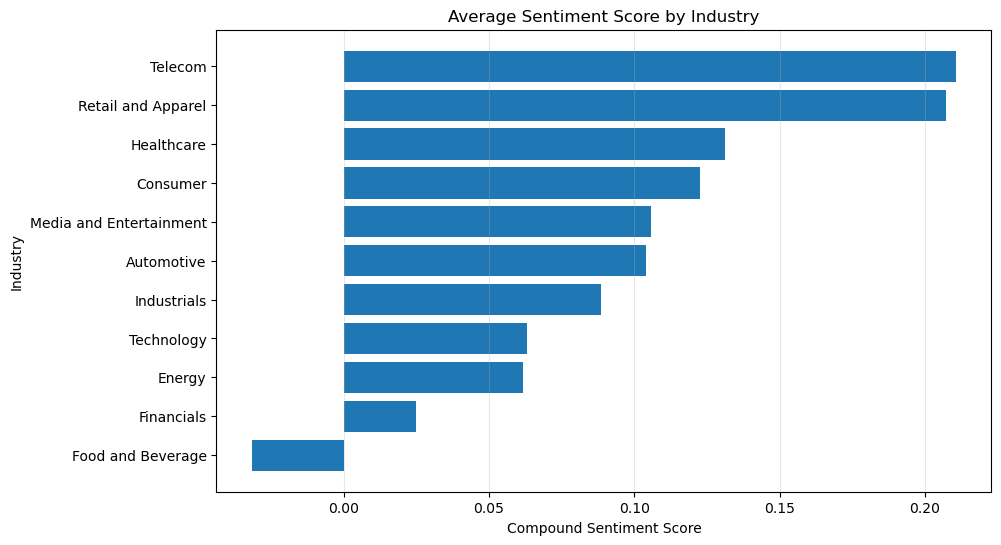

In [63]:
industry_avg = (
    news_with_sentiment
    .groupby("industry")["compound"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(10, 6))
plt.barh(industry_avg.index, industry_avg.values)
plt.title("Average Sentiment Score by Industry")
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Industry")
plt.grid(axis="x", alpha=0.3)
plt.show()


This shows you which industries are most positive or negative.

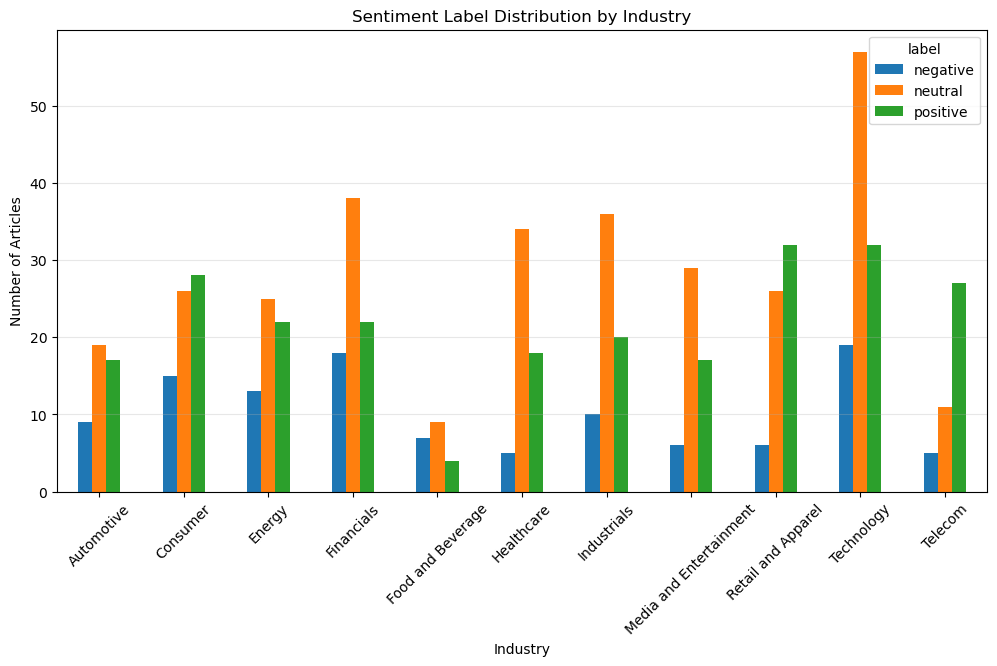

In [66]:
label_counts = (
    news_with_sentiment
    .groupby(["industry", "label"])
    .size()
    .unstack(fill_value=0)
)

label_counts.plot(kind="bar", figsize=(12, 6))
plt.title("Sentiment Label Distribution by Industry")
plt.xlabel("Industry")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()


This visualises how many positive or negative articles each industry gets.

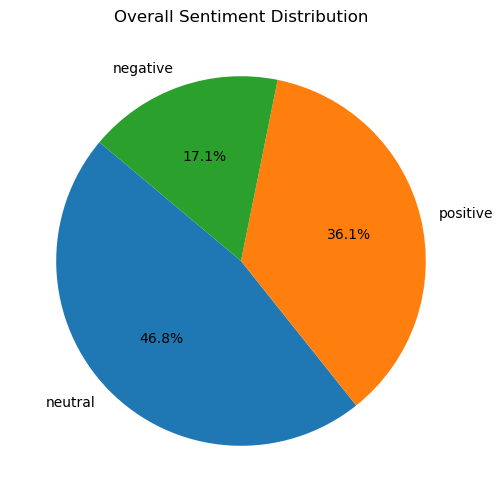

In [69]:
overall_counts = news_with_sentiment["label"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    overall_counts.values,
    labels=overall_counts.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Overall Sentiment Distribution")
plt.show()


Shows how balanced our dataset is.

<Figure size 1200x600 with 0 Axes>

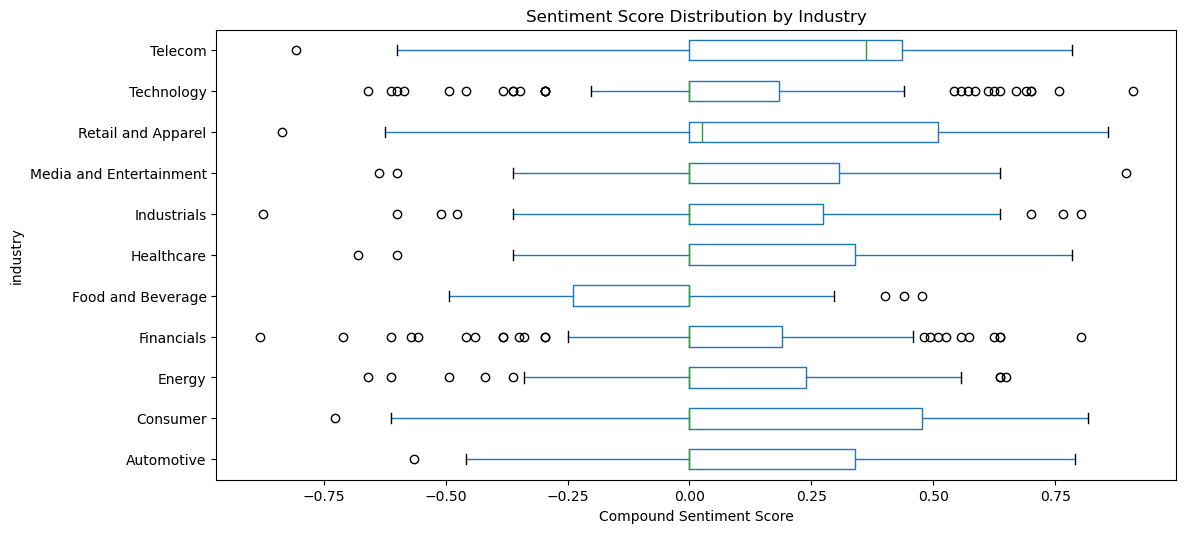

In [72]:
plt.figure(figsize=(12, 6))
news_with_sentiment.boxplot(
    column="compound",
    by="industry",
    figsize=(12, 6),
    grid=False,
    vert=False
)
plt.title("Sentiment Score Distribution by Industry")
plt.suptitle("")
plt.xlabel("Compound Sentiment Score")
plt.show()


This shows how volatile sentiment is within each industry.

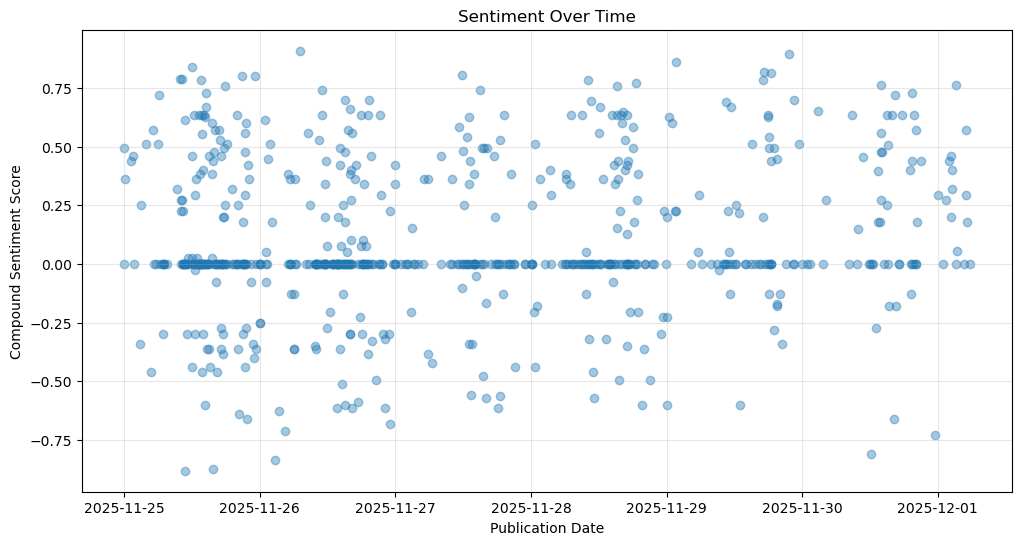

In [75]:
news_with_sentiment["published_at"] = pd.to_datetime(news_with_sentiment["published_at"])

plt.figure(figsize=(12, 6))
plt.scatter(
    news_with_sentiment["published_at"],
    news_with_sentiment["compound"],
    alpha=0.4
)
plt.title("Sentiment Over Time")
plt.xlabel("Publication Date")
plt.ylabel("Compound Sentiment Score")
plt.grid(alpha=0.3)
plt.show()


This explores time trends

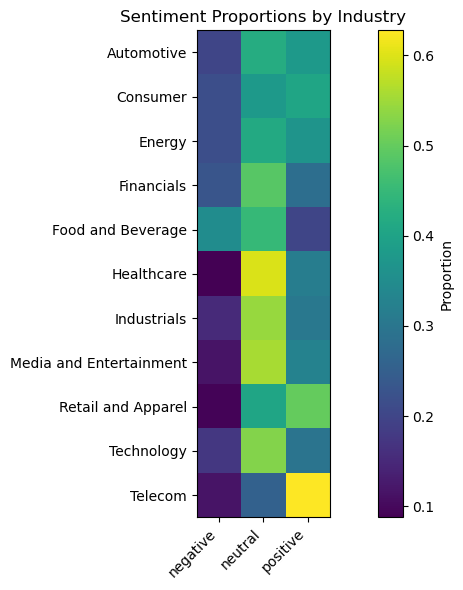

In [80]:
plt.figure(figsize=(10, 6))
plt.imshow(heat_data, cmap="viridis")
plt.colorbar(label="Proportion")
plt.xticks(
    ticks=np.arange(len(heat_data.columns)),
    labels=heat_data.columns,
    rotation=45,
    ha="right"
)
plt.yticks(ticks=np.arange(len(heat_data.index)), labels=heat_data.index)
plt.title("Sentiment Proportions by Industry")
plt.tight_layout()
plt.show()

## Final Conclusion

The goal of this project was to build a complete sentiment analysis pipeline that collects real news data across multiple industries, analyses the sentiment of each headline, and compares industries using visual insights. By combining the NewsAPI data fetcher with a custom VADER based SentimentAnalyzer, I created a large dataset of industry labelled articles and produced a detailed sentiment comparison.

### Summary of the Process

I began by defining a set of industries and assigning each one several representative companies or keywords. Using NewsAPI, I collected recent English language news headlines and stored them in a clean, structured DataFrame. I then applied my SentimentAnalyzer to each headline to compute negative, neutral, positive, and compound sentiment scores, as well as an overall sentiment label.

This produced a final dataset that included article metadata, industry category, and sentiment scores. I used this dataset to generate a range of visualisations that highlight sentiment trends and differences across industries.

### Key Findings from the Visualisations

1. **Average sentiment by industry**  
   The horizontal bar chart shows that Telecom and Retail and Apparel have the highest average sentiment scores, while Food and Beverage has the lowest. Most industries cluster around a mildly positive average sentiment, which suggests that financial news tends to use moderately positive or neutral language.

2. **Sentiment label distribution**  
   The grouped bar chart indicates that neutral headlines are the most common sentiment category in nearly every industry. Positive headlines appear frequently in sectors such as Technology, Retail and Apparel, and Consumer. Negative headlines are present but form the smallest share overall.

3. **Overall sentiment distribution**  
   The pie chart confirms that neutral sentiment dominates the dataset. Positive sentiment appears in roughly one third of headlines, while negative sentiment forms a smaller proportion. This matches typical patterns in financial reporting, which often aims for neutral or factual language.

4. **Sentiment score variability**  
   The boxplot shows that every industry contains a wide spread of sentiment values, including occasional highly positive and highly negative headlines. This variability reflects how industry specific events can drive sudden changes in tone.

5. **Sentiment over time**  
   The scatter plot demonstrates how sentiment fluctuates across the date range. Headlines cluster around neutral values, but positive and negative spikes appear throughout the period. This confirms that market related sentiment changes continuously with news events.

6. **Heatmap of sentiment proportions**  
   The heatmap provides a clear overview of how each industry is distributed across negative, neutral, and positive sentiment. Healthcare, Telecom, and Retail and Apparel show relatively high proportions of positive articles, while Food and Beverage has a higher share of negative sentiment.

### Overall Conclusion

This project shows that it is possible to create a complete sentiment analysis pipeline using real news sources and a custom Python implementation. The combined dataset and visuals reveal clear differences in sentiment across industries, with some sectors consistently receiving more positive coverage than others. Despite this variation, neutral sentiment dominates most headlines, reflecting the informational style of financial news reporting.

By integrating data collection, text processing, sentiment scoring, and visual exploration, this project demonstrates a full workflow for analysing real world sentiment across multiple sectors. It also provides a foundation for future extensions, such as predictive modelling, time series analysis, or comparisons between different news sources.
